
# Final model fitting

_Note: It is essential to maintain the same parameters throughout hyperparameter optimization and final model fitting (e.g. random states, train/test/validate fractions, imbalance limits, etc.). The one exception is that the number of balanced folds that are sampled can be changed largely without consequence_

In [2]:
import TRANSPIRE

import pandas as pd
import numpy as np

## 1. Load data, define comparisons, and generate synthetic translocations

In [3]:
f = 'mydata.csv'
df = TRANSPIRE.data.import_data.load_data(f)

comparisons = [('uninfected', 'infected')]

synthetic_translocations = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons)
mapping, mapping_r = TRANSPIRE.utils.get_mapping(df)

synthetic_translocations.head()

1   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.121081   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.121081   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   

                                                                                                                                                          2   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.378059   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.378059   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   

                                                                                                                                                          3   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.287889   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.287889   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   

                                                                                                                                                          4   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.142575   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.142575   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.1

## 2. Split the data into training, validation and testing partitions

In [19]:
f_train = 0.5 # fraction dedicated to training data
f_validate = 0.25 # fraction dedicated to validation (i.e. used to assess hyperparameter performance)
f_test = 0.25 # fraction dedicated to assessing final predictive performance

levels = ['condition_A', 'condition_B', 'label'] # groupby levels to take stratified samples from

X_train_df, X_validate_df, X_test_df = TRANSPIRE.utils.train_test_validate_split(synthetic_translocations, 
                                                                                 levels, 
                                                                                 f_train, 
                                                                                 f_validate, 
                                                                                 f_test)

X_train_validate = pd.concat([X_train_df, X_validate_df])

Splitting data into training, validation, and testing folds (this may take a while) . . . done


## 3. Split the training data into a given number of class-balanced folds

**Note that the training data, here, consists of the training AND validation partitions**

Depending on the number of markers in each class, the synthetic translocations generated may have a high level of class-imbalance. If there is overlap between organelle marker clases, this can result in classifier predictions that are biased toward the class with more samples.

To prevent prediction bias due to class imbalance, TRANSPIRE has a utility for generating different folds of balanced training data based on a given "imbalance_limit."

In general, more folds will yield better coverage of the training data, but at the expense of computation time. A highter imbalance_limit will overall increase coverage of the training data for a given fold, but may lead to poor model performance if there is high overlap between classes.

_Note: In contrast to k-fold cross-validation, these folds will overlap for any classes where the number of samples is less-than n_limit * n_folds_

In [6]:
imbal_limit = 3 # maximum fold difference between smallest and largest class sizes
n_limit = X_train_validate.groupby(['condition_A', 'condition_B']).apply(lambda y: y.groupby('label').size().min()*imbal_limit)

print('The total number of folds required to cover all of the training data for each class is: {}'.format(int(np.ceil(X_train_validate.groupby(['condition_A', 'condition_B']).apply(lambda y: max(y.groupby('label').size()/n_limit[y.name])).max()))))

The total number of folds required to cover all of the training data for each class is: 131


In [7]:
n_folds = 23 # number of balanced folds to sample from the dataset (note that these folds will overlap for any classes where its size < n_folds*n_limit)
training_data = X_train_validate.groupby(['condition_A', 'condition_B'], group_keys=False).apply(lambda x: TRANSPIRE.utils.sample_balanced(x, n_limit[x.name], n_folds))

Creating balanced training partitions (this may take a while).... done


## 4. Define model parameters and architecture

In [10]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow

# where to save the models (make sure that this path exists)
base_dir = r'final_models'

# n_induce and kern_func found via hyperparameter optimization (or not...)
n_induce = 30
kern_func = gpflow.kernels.SquaredExponential

# max number of calls to the optimizer for each model that is built
maxiter = 200

# learning rate for the Adam optimizer 
# too low of a learning rate will prevent the model from reaching an optimal solution
# too high and the fitting may diverge
# 0.05 is a good starting point
learning_rate = 0.05

# whether to implement interactive plotting to track fit progress
plot_fit = True

## 5. Compute inducing points up-front (optional)

There are no downsides to performing this step, but it will prevent repeat KMeans fitting of the inducing points in the event that there are multiple hyperparameter combinations with the same n_induce or multiple folds are fitted

In [11]:
import TRANSPIRE.training

# fit KMeans to training data for different n_induce
Z_induce = {}

for k, x in training_data.groupby(['condition_A', 'condition_B', 'fold']):

    Z_induce[k] = TRANSPIRE.training.compute_inducing(x, n_induce)


## 6. Train and save models for n-folds of each combination of conditions defined in comparisons

**custom callback to visualize model training**

In [12]:
%matplotlib inline

from IPython import display

class PlottingCallback(TRANSPIRE.training.ProgressTracker):
    def __init__(self, m, X, Y, update_interval):
        super().__init__(m, X, Y)
        
        self.calls = 0
        self.update_interval = update_interval
        self.update()
        
        ax.set_xlim(0, maxiter+1)
        ax.set_ylim(self.elbo[0], 0)
        ax_2.set_ylim(0, 1)
         
    def update_plot(self, i):
        self.calls+=1
        self.update()
                
        if self.calls%self.update_interval == 0:
            ax.set_title('iteration # {}'.format(self.calls))
        
            x = [int(self.update_interval*i) for i in range(int(np.ceil(len(self.elbo)/self.update_interval)))]
            elbo = [np.mean(np.array(self.elbo)[x[i]:x[i+1]]) for i in range(len(x)-1)]
            acc = [np.mean(np.array(self.acc)[x[i]:x[i+1]]) for i in range(len(x)-1)]
           
            elbo_line, = ax.plot(x[:-1], elbo, color = 'grey', label='ELBO')
            acc_line, = ax_2.plot(x[:-1], acc, color='steelblue', label= 'accuracy')
            
            ax.set_xlabel('iteration #')
            ax.set_ylabel('ELBO')
            ax_2.set_ylabel('accuracy')
            
            ax.legend(handles=[elbo_line, acc_line], loc=4)

            fig.tight_layout()
            
            display.clear_output(wait=True)
            display.display(fig)
    

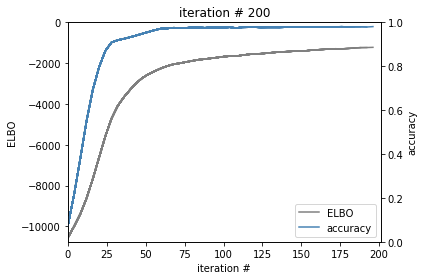

In [17]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow
import os

%matplotlib inline

gpflow.reset_default_graph_and_session()

if plot_fit == True:

    import matplotlib.pyplot as plt
    
    # for tracking fitting progress
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_2 = ax.twinx()
    plt.show()

# build and fit a model for each set of conditions for each fold of training data
for (condA, condB, fold), X_train in training_data.groupby(['condition_A', 'condition_B', 'fold']):
    
    X = X_train.values
    y = X_train.index.get_level_values('label').map(mapping).values.reshape(-1, 1) # encode labels
    Z = Z_induce[k] # set of inducing points already pre-calculated

    # define kernel function (with noise kernel added)
    kernel = kern_func(X.shape[1], ARD=True) + gpflow.kernels.White(X.shape[1], variance=1)

    # parameters required to build model
    model_params = {

        'Z': Z, # if Z is omitted from this dict, KMeans will be used to find n_inducing points during moldel generation
        'n_induce': n_induce, # only really required if Z is omitted
        'kernel': kernel,
    }

    # build the SVGP model
    m = TRANSPIRE.training.build_model(X, y, **model_params)

    # allow the optimizer to train both inducing points and the noise level (optional...one or more may be set to false--up to user-discresssion)
    m.feature.Z.trainable = True
    m.kern.kernels[1].trainable = True

    session = gpflow.get_default_session()

    if plot_fit == True:
        
        ax.clear()
        ax_2.clear()
        window = max(1, int(maxiter/50))
        callback = PlottingCallback(m, X, y, window)
        
        opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
        opt.minimize(m, maxiter=maxiter, step_callback=callback.update_plot)

    else:

        opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
        opt.minimize(m, maxiter=maxiter)

    # save the optimized model 
    m.anchor(session)
    gpflow.saver.Saver().save(os.path.join(base_dir, 'ELBO={:.0f}_{}_{}_{}'.format(m.compute_log_likelihood(X), condA, condB, fold)), m)

    # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
    gpflow.reset_default_graph_and_session()
    


## 7. Evaluate each model on the testing data

In [23]:
import os

eval_limit = 10000 # max number of samples to evaluate at once (conserve RAM usage)
n_chunks = int(np.ceil(X_test_df.shape[0]/eval_limit))

result = {}

gpflow.reset_default_graph_and_session()

for k, _ in training_data.groupby(['condition_A', 'condition_B', 'fold']):
    
    condA, condB, fold = k
    
    m_path = [path for path in os.listdir(base_dir) if (all([str(s) in path for s in k])&(path.endswith('_{}'.format(k[-1]))))][0]
    
    if os.path.exists(os.path.join(base_dir, m_path)):
        m = gpflow.saver.Saver().load(os.path.join(base_dir, m_path))

        X = X_test_df[(X_test_df.index.get_level_values('condition_A')==condA) &(X_test_df.index.get_level_values('condition_B')==condB)]

        means = []
        vars_ = []

        for i, arr in enumerate(np.array_split(X, n_chunks)):
            mns, vrs_ = m.predict_y(arr.values)

            mns = pd.DataFrame(mns, index=arr.index).reset_index(['condition_A', 'condition_B'], drop=True)
            vrs_ = pd.DataFrame(vrs_, index = arr.index).reset_index(['condition_A', 'condition_B'], drop=True)

            means.append(mns)
            vars_.append(vrs_)

        means = pd.concat(means)
        vars_ = pd.concat(vars_)

        result[(condA, condB, fold)] = pd.concat([means, vars_], axis=1, keys = ['score','uncertainty'])

        gpflow.reset_default_graph_and_session()
        
        print(m_path)

    
result = pd.concat(result, names = ['condition_A', 'condition_B', 'fold'])

ELBO=-1207_uninfected_infected_1
ELBO=-1208_uninfected_infected_2
ELBO=-1214_uninfected_infected_3
ELBO=-1329_uninfected_infected_4
ELBO=-1235_uninfected_infected_5
ELBO=-1271_uninfected_infected_6
ELBO=-1210_uninfected_infected_7
ELBO=-1223_uninfected_infected_8
ELBO=-1241_uninfected_infected_9
ELBO=-1242_uninfected_infected_10
ELBO=-1228_uninfected_infected_11
ELBO=-1234_uninfected_infected_12
ELBO=-1220_uninfected_infected_13
ELBO=-1249_uninfected_infected_14
ELBO=-1207_uninfected_infected_15
ELBO=-1253_uninfected_infected_16
ELBO=-1255_uninfected_infected_17
ELBO=-1256_uninfected_infected_18
ELBO=-1207_uninfected_infected_19
ELBO=-1241_uninfected_infected_20
ELBO=-1213_uninfected_infected_21
ELBO=-1251_uninfected_infected_22
ELBO=-1207_uninfected_infected_23


## 9. Evaluate predictive performance


In [28]:
import TRANSPIRE.performance

performance = result.score.groupby(['condition_A', 'condition_B', 'fold']).apply(lambda x: TRANSPIRE.performance.eval_report(x, mapping, mapping_r))

**Evaluation metrics**

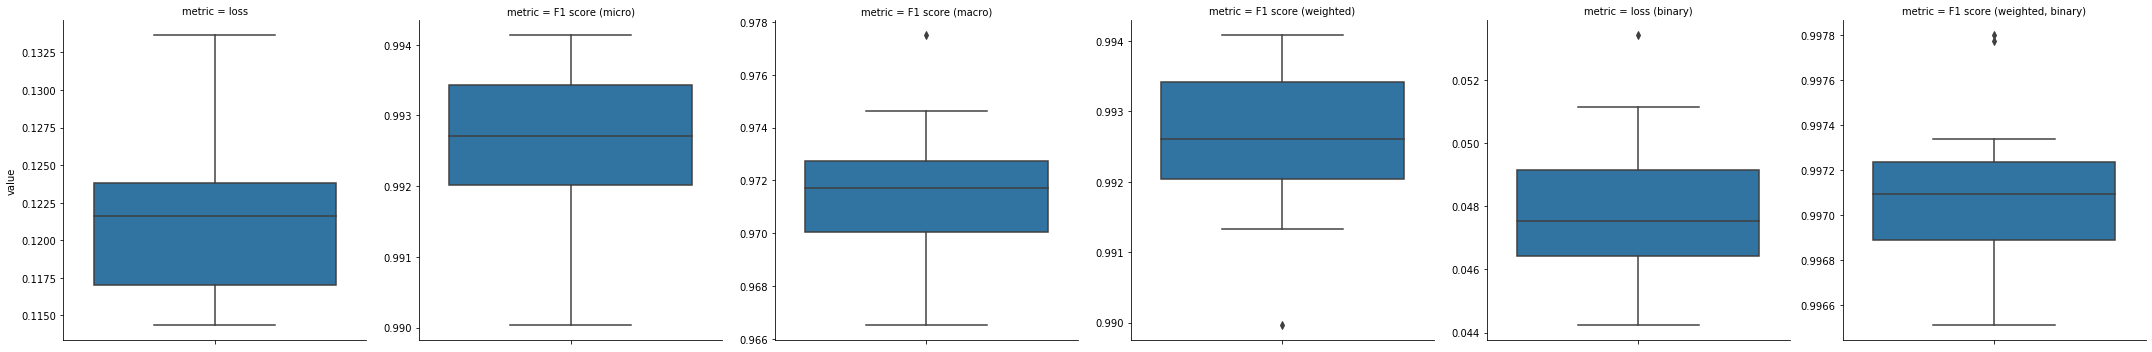

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

temp = performance['singular metrics'].dropna()
sns.catplot(data=temp.reset_index().melt(temp.index.names), col='metric', sharey=False, y='value', kind='box')

plt.show()

**Per-class performance**

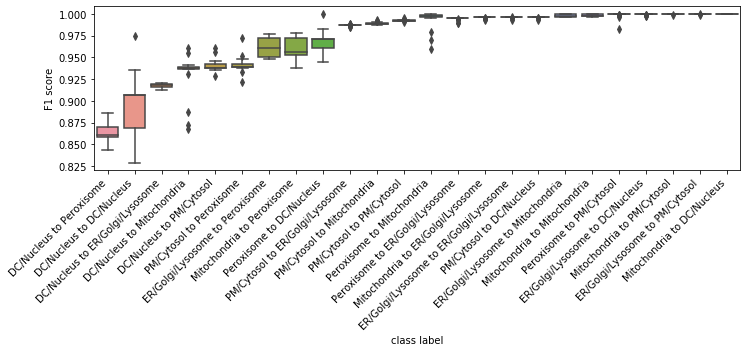

In [34]:
temp = performance['F1 score (per class)']

fig, ax = plt.subplots(figsize = (10.5, 5))

order = temp.mean().sort_values().index.values.tolist()

sns.boxplot(data=temp.reset_index().melt(temp.index.names), hue='metric', x='metric', y='value', 
            dodge=False, order=order, hue_order=order)

ax.get_legend().remove()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('class label')
ax.set_ylabel('F1 score')

fig.tight_layout()
plt.show()

## 10. Compute FPR cutoff(s) for translocation scores

In [40]:
binary = TRANSPIRE.utils.map_binary(result.score, mapping_r)
fprs = binary.groupby(['condition_A', 'condition_B', 'fold']).apply(TRANSPIRE.performance.compute_fpr)

cutoff_fpr = 0.01 # 1% FPR cutoff
cutoffs = fprs[fprs<cutoff_fpr].idxmax(axis=1).groupby(['condition_A', 'condition_B']).mean()

In [41]:
cutoffs

condition_A  condition_B
uninfected   infected       0.448397
dtype: float64

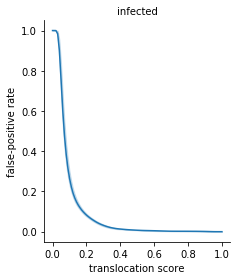

In [43]:
g=sns.FacetGrid(data=fprs.reset_index().melt(fprs.index.names), col='condition_B', 
                height=4, aspect = 0.85,
                hue='condition_B',

               )
g.map(sns.lineplot, 'variable', 'value', ci='sd')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

for i, ax in enumerate(g.axes.flatten()):
    ax.set_xlabel('translocation score')

    if i==0:
        ax.set_ylabel('false-positive rate')

ax.get_figure().tight_layout()

plt.show()

## 11. Evaluate models on the actual data
**load models and evaluate the actual data**

In [44]:
# concatenate actual protein profiles between conditions
actual_profiles = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons, synthetic=False)

predicted_scores = {}

for k, _ in training_data.groupby(['condition_A', 'condition_B', 'fold']):
    
    condA, condB, fold = k
    
    X = actual_profiles[(actual_profiles.index.get_level_values('condition_A')==condA)&(actual_profiles.index.get_level_values('condition_B')==condB)].reset_index(['condition_A', 'condition_B'], drop=True)

    m_path = [path for path in os.listdir(base_dir) if (all([str(s) in path for s in k])&(path.endswith('_{}'.format(k[-1]))))][0]

    m = gpflow.saver.Saver().load(os.path.join(base_dir, m_path))

    means, vars_ = m.predict_y(X.values)
    means = pd.DataFrame(means, index=X.index)
    vars_ = pd.DataFrame(vars_, index = X.index)

    predicted_scores[k] = pd.concat([means, vars_], axis=1, keys = ['score', 'uncertainty'])

    gpflow.reset_default_graph_and_session()
    
predicted_scores = pd.concat(predicted_scores, names = ['condition_A', 'condition_B', 'fold'])

# average predictions across balanced folds
predicted_scores = predicted_scores.stack([0, 1]).unstack('fold').mean(axis=1).unstack([-2, -1])

**Map the predictions to their binary representation**

In [62]:
binary_predictions = TRANSPIRE.utils.map_binary(predicted_scores.score, mapping_r)

binary_predictions.head()

translocation score
condition_A condition_B accession_A gene name_A localization_A accession_B gene name_B localization_B                     
uninfected  infected    A0AVT1      UBA6        NaN            A0AVT1      UBA6        NaN                        0.934178
                        A0FGR8      ESYT2       NaN            A0FGR8      ESYT2       NaN                        0.182076
                        A1L0T0      ILVBL       NaN            A1L0T0      ILVBL       NaN                        0.234037
                        A2RRP1      NBAS        NaN            A2RRP1      NBAS        NaN                        0.656223
                        A3KMH1      VWA8        NaN            A3KMH1      VWA8        NaN                        0.126233

**Determine which ones pass the defined FPR cutoff based on translocation score**

In [63]:
passes_fpr_cutoff = binary_predictions['translocation score']>= cutoffs.loc[list(zip(binary_predictions.index.get_level_values('condition_A'), binary_predictions.index.get_level_values('condition_B')))].values

## 12. Process and  save results

In [78]:
pred_score = predicted_scores.score.max(axis=1)
pred_label = predicted_scores.score.idxmax(axis=1).astype(int).map(mapping_r)

processed_data = pd.concat([pred_score, pred_label, binary_predictions['translocation score'], passes_fpr_cutoff], axis=1, keys = ['predicted score', 'predicted label', 'translocation score', 'passes cutoff?'])

In [80]:
processed_data.to_csv(os.path.join('results.csv'))